## Import necessary libraries

In [1]:
from music21 import *
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import torch.nn.functional as F
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

2024-03-18 11:30:40.785806: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 11:30:41.045013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 11:30:41.045105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 11:30:41.078433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 11:30:41.157394: I tensorflow/core/platform/cpu_feature_guar

cpu


## Loading the Preprocessed Train Dataset

In [2]:
import pandas as pd
from ast import literal_eval

notes_df = pd.read_csv ('/home/admin1/Desktop/NEWLSTM/csv_dataset/notes.csv')
train_df = pd.read_csv ('/home/admin1/Desktop/NEWLSTM/csv_dataset/trainset.csv')
validation_df = pd.read_csv ('/home/admin1/Desktop/NEWLSTM/csv_dataset/validationset.csv')

data_train = train_df[['x_tr','future']].to_numpy()
data_validation = validation_df[['x_val','future']].to_numpy()

x_tr_string = data_train[:,0]
y_tr_string = data_train[:,1]
x_tr = []
y_tr = []
for i in x_tr_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_x_tr = [int(j) for j in i.split()]
    x_tr.append(input_x_tr)

for i in y_tr_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_y_tr = [int(j) for j in i.split()]
    y_tr.append(input_y_tr)
x_tr = np.array(x_tr)
y_tr = np.array(y_tr)
    
# print(x_tr.shape,y_tr.shape)

x_val_string = data_validation[:,0]
y_val_string = data_validation[:,1]
x_val = []
y_val = []
for i in x_val_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_x_val = [int(j) for j in i.split()]
    x_val.append(input_x_val)

for i in y_val_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_y_val = [int(j) for j in i.split()]
    y_val.append(input_y_val)
x_val = np.array(x_val)
y_val = np.array(y_val)

# print(x_val.shape,y_val.shape)

notes_ = notes_df['0'].to_numpy().flatten()
unique_notes_reverse = dict(enumerate(notes_.flatten(), 1))
unique_notes = {value : key for (key, value) in unique_notes_reverse.items()}

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class MusicDataset(Dataset):
    def __init__(self, data , data_labels):
        self.data = data
        self.data_labels = data_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx] , self.data_labels[idx]

In [4]:
batch_size = 8
train_set = MusicDataset(x_tr,y_tr)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [5]:
val_set = MusicDataset(x_val,y_val)
validationloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

## Model Initialization

In [6]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, num_classes):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        
        self.embedding = nn.Embedding(num_classes, 100)
        self.lstm = nn.LSTM(input_size=100, hidden_size=256, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the last timestep's output
        x = self.fc1(lstm_out)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [8]:
seq_length = 32  # This is the length of the input sequences

# Instantiate the LSTM model
Net = LSTM(num_classes=len(unique_notes))

# Move the model to the appropriate device
Net.to(device)

# Print the model architecture
print(Net)

LSTM(
  (embedding): Embedding(301, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=301, bias=True)
)


In [9]:
num_classes1 = len(unique_notes)  # The number of unique notes
seq_length1 = x_tr.shape[1]

In [10]:
print(num_classes1, seq_length1)

301 32


In [11]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

## Initialize the path where we will save the model

In [12]:
import time , sys
baseDir = '/home/admin1/Desktop/NEWLSTM/BaseDIR'
expDir = os.path.join(baseDir, 'trained_model_cache', time.strftime("%d_%m_%Y_%H_%M"))
lossDir = os.path.join(expDir, 'loss')
os.makedirs(expDir, exist_ok=True)
os.makedirs(lossDir, exist_ok=True)
print(baseDir,expDir)

/home/admin1/Desktop/NEWLSTM/BaseDIR /home/admin1/Desktop/NEWLSTM/BaseDIR/trained_model_cache/18_03_2024_11_31


In [13]:
loss_history = []
best_val_acc = 0
training_mode_list = ["Next_Predict_Mode","Future_Predict_Mode"]
training_mode = "Next_Predict_Mode"
future_preds = 5

## Start actual Training

In [15]:
import timeit


''' TRAINING THE MODEL '''
correct_preds = 0
total_preds = 0
for epoch in range(25): 
    running_loss = 0.0
    start = timeit.default_timer()
    for i, data in enumerate(trainloader, 0):
        input , label = data
        optimizer.zero_grad()
        if training_mode == training_mode_list[0]:
            #output = Net(input.to(device),input.shape[0])
            output = Net(input.to(device))
            loss = criterion(output.to(device), label[:,0].to(device))
            loss.backward()
            optimizer.step()
            total_preds += input.shape[0]
            correct_preds += torch.sum(torch.argmax(output,1) == label[:,0].to(device))

            running_loss += loss.item()
        elif training_mode == training_mode_list[1]:
            cumm_output = torch.zeros(0,len(unique_notes)).to(device)
            cumm_label  = np.array([],dtype=int)
            for k in range(future_preds):
                output = Net(input.to(device),input.shape[0])
                cumm_output = torch.cat((cumm_output,output))
                cumm_label = np.concatenate((cumm_label,label[:,k]))
                next_preds = np.argmax(output.cpu().detach().numpy(),axis=1)
                input = input.cpu().detach().numpy()
                input = torch.from_numpy(np.array([np.append(j,next_preds[ind]) 
                                                       for ind,j in enumerate(input)])[:,1:])  
            loss = criterion(cumm_output, torch.from_numpy(cumm_label).to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        if (i % 300 == 299  ):
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 300))
            loss_history.append(running_loss/300)
            running_loss = 0.0
    stop = timeit.default_timer()
    print(f"Training Time for Epoch :{epoch} \n {stop-start} seconds\n")
    train_acc =  float(correct_preds)/float(total_preds) *100 
    trainreport ="Training Accuracy : \n correct predictions  : {} \n total predictions : {} \n Training Accuracy : {} \n ------------------------\n".format(correct_preds,total_preds,train_acc)
    print(trainreport)     
    correct_preds = 0
    total_preds = 25
    val_loss = 0
    start = timeit.default_timer()
    for i, data in enumerate(validationloader, 0):
        input , label = data
        if training_mode == training_mode_list[0]:
            #output = Net(input.to(device),input.shape[0])
            output = Net(input.to(device))
            loss = criterion(output.to(device), label[:,0].to(device))
            total_preds += input.shape[0]
            correct_preds += torch.sum(torch.argmax(output,1) == label[:,0].to(device))
            val_loss += loss.item()
            
        elif training_mode == training_mode_list[1]:
            cumm_output = torch.zeros(0,len(unique_notes)).to(device)
            cumm_label  = np.array([],dtype=int)
            for k in range(future_preds):
                output = Net(input.to(device),input.shape[0])
                cumm_output = torch.cat((cumm_output,output))
                cumm_label = np.concatenate((cumm_label,label[:,k]))
                next_preds = np.argmax(output.cpu().detach().numpy(),axis=1)
                input = input.cpu().detach().numpy()
                input = torch.from_numpy(np.array([np.append(j,next_preds[ind]) 
                                                       for ind,j in enumerate(input)])[:,1:])  
            loss = criterion(cumm_output, torch.from_numpy(cumm_label).to(device))

            val_loss += loss.item()
    stop = timeit.default_timer()
    print(f"Validation Time for Epoch :{epoch} \n {stop-start} seconds\n")
    val_acc = float(correct_preds)/float(total_preds) *100
    val_loss = float(val_loss)/float(total_preds)
    valreport ="Validation Accuracy : \n correct predictions  : {} \n total predictions : {} \n Val-Loss : {} \n Val-Accuracy :{}----------------------------------\n".format(correct_preds,total_preds,val_loss,val_acc )
    print(valreport)
    
    if(val_acc > best_val_acc):
        print('Updating the model')
        best_val_acc = val_acc
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": Net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_acc": train_acc,
            "valid_acc": val_acc
        }
        torch.save(checkpoint, os.path.join(expDir, 'checkpoint.tar'))
        torch.save(Net, os.path.join(expDir, 'model.pth'))
    
    correct_preds = 0
    
    total_preds = 0


print('Finished Training')

[1,   300] loss: 5.290
[1,   600] loss: 5.132
[1,   900] loss: 5.123
[1,  1200] loss: 5.070
[1,  1500] loss: 5.048
[1,  1800] loss: 5.030
[1,  2100] loss: 4.955
[1,  2400] loss: 4.929
[1,  2700] loss: 4.902
[1,  3000] loss: 4.866
[1,  3300] loss: 4.845
[1,  3600] loss: 4.775
[1,  3900] loss: 4.744
[1,  4200] loss: 4.775
[1,  4500] loss: 4.783
[1,  4800] loss: 4.720
[1,  5100] loss: 4.742
[1,  5400] loss: 4.701
[1,  5700] loss: 4.689
[1,  6000] loss: 4.655
[1,  6300] loss: 4.661
[1,  6600] loss: 4.682
[1,  6900] loss: 4.653
[1,  7200] loss: 4.663
[1,  7500] loss: 4.647
[1,  7800] loss: 4.642
[1,  8100] loss: 4.648
[1,  8400] loss: 4.641
[1,  8700] loss: 4.641
[1,  9000] loss: 4.547
[1,  9300] loss: 4.580
[1,  9600] loss: 4.623
[1,  9900] loss: 4.573
[1, 10200] loss: 4.573
[1, 10500] loss: 4.570
[1, 10800] loss: 4.587
[1, 11100] loss: 4.569
[1, 11400] loss: 4.538
[1, 11700] loss: 4.497
Training Time for Epoch :0 
 562.350123494 seconds

Training Accuracy : 
 correct predictions  : 4195 


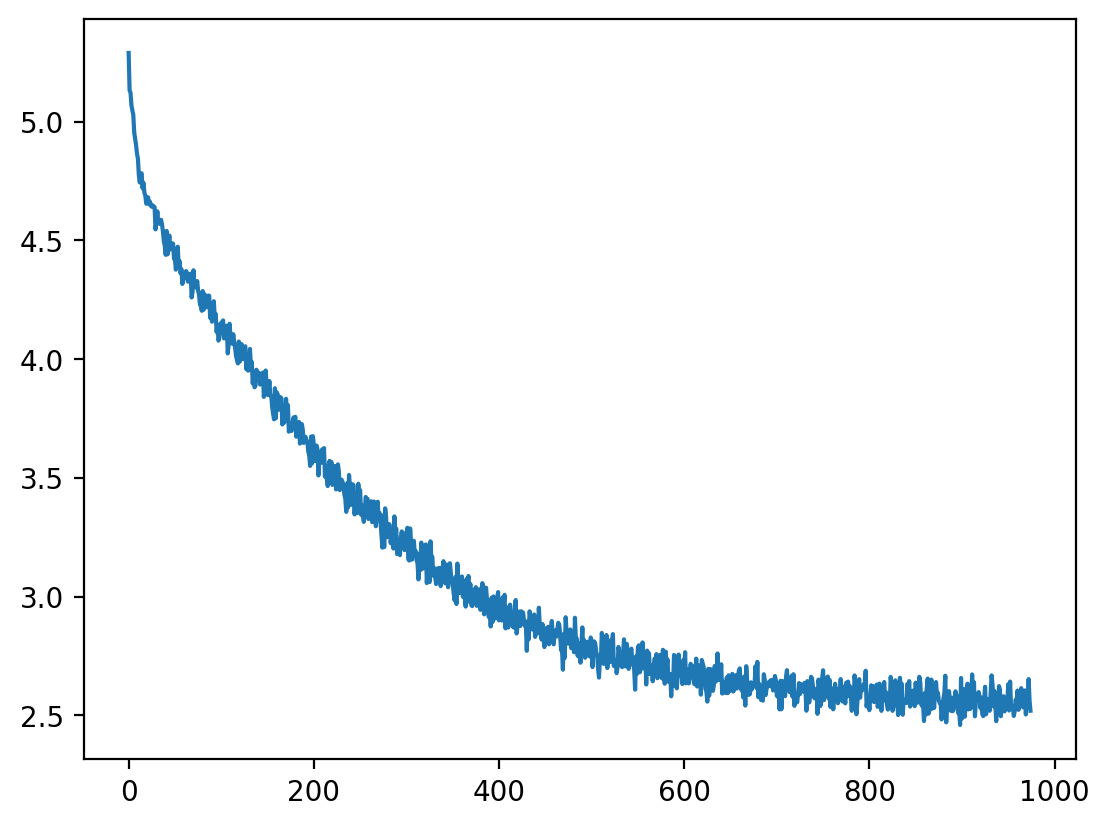

In [16]:
lossDir = '/home/admin1/Desktop/NEWLSTM'

plt.figure()
plt.plot(loss_history)
plt.savefig(lossDir + '/loss_history.png')

## Save the Trained Model

In [17]:
path='/home/admin1/Desktop/NEWLSTM/state_dictionary/lstmmodel_basic.pth'
torch.save(Net.state_dict(), path)

In [18]:
# Now save the model's state
checkpoint_path = '/home/admin1/Desktop/NEWLSTM/checkpoint_path/checkpoint.tar'
torch.save({
    'epoch': 20,  # replace 'epoch' with the current epoch number
    'model_state_dict': Net.state_dict(),
    # Include any other states or variables if needed
}, checkpoint_path)

In [19]:
checkpoint = torch.load(checkpoint_path)
Net.load_state_dict(checkpoint["model_state_dict"])
print(checkpoint["epoch"])

20
